#### Setup

In [324]:
%pip install -q numpy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [325]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### SGD

In [326]:
def sgd(x, y, mini_batch_size=1, learning_rate=0.001, n_epochs=10):
    # Reshaping
    try:
        m, n = x.shape
    except:
        x = x[:, np.newaxis]
        m, n = x.shape
    
    x_b = np.c_[np.ones((m, 1)), x]
    theta = np.random.randn(n+1, 1)*0.01
    
    trainloss_history = []

    # Calculate the number of batches per epoch
    n_batches = m // mini_batch_size
    
    for epoch in range(n_epochs):
        indices = np.random.permutation(m)
        x_shuffled = x_b[indices]
        y_shuffled = y[indices]
        
        for i in range(n_batches):
            start_idx = i * mini_batch_size
            end_idx = start_idx + mini_batch_size
            x_batch = x_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx].reshape(-1, 1)
            
            predictions = x_batch.dot(theta)
            errors = y_batch - predictions
            gradients = (-2./len(x_batch)) * x_batch.T.dot(errors)
            theta -= learning_rate * gradients
        
        y_pred = x_b.dot(theta)
        MSE = np.mean((y.reshape(-1, 1) - y_pred) ** 2)
        trainloss_history.append(MSE)
    
    return theta, trainloss_history

#### Adam

In [ ]:
def adam(x, y, mini_batch_size, learning_rate, n_epochs, beta1, beta2, epsilon):
    # Reshaping
    try:
        m, n = x.shape
    except:
        x = x[:, np.newaxis]
        m, n = x.shape
    
    x_b = np.c_[np.ones((m, 1)), x]
    theta = np.random.randn(n+1, 1)*0.01

    # First moment and second moment estimates
    m_t = np.zeros_like(theta)
    v_t = np.zeros_like(theta)
    
    trainloss_history = []
    n_batches = max(1, m // mini_batch_size)
    
    t = 0    
    for epoch in range(n_epochs):
        indices = np.random.permutation(m)
        x_shuffled = x_b[indices]
        y_shuffled = y[indices]
        
        for i in range(n_batches):
            t +=1
            start_idx = i * mini_batch_size
            end_idx = min(start_idx + mini_batch_size, m)
            x_batch = x_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx].reshape(-1, 1)
            
            # Calculate predictions, errors and gradients
            predictions = x_batch.dot(theta)
            errors = y_batch - predictions
            gradients = (-2./len(x_batch)) * x_batch.T.dot(errors)
            
            m_t = beta1 * m_t + (1 - beta1) * gradients
            v_t = beta2 * v_t + (1 - beta2) * (gradients ** 2)
            m_hat = m_t / (1 - beta1 ** t)
            v_hat = v_t / (1 - beta2 ** t)
            
            # Update theta
            theta -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        
        y_pred = x_b.dot(theta)
        MSE = np.mean((y.reshape(-1, 1) - y_pred) ** 2)
        trainloss_history.append(MSE)
    
    return theta, trainloss_history

#### ADMM

In [328]:
def admm(x, y, n_epochs, rho, reg_lambda):
    # Reshaping
    try:
        m, n = x.shape
    except:
        x = x[:, np.newaxis]
        m, n = x.shape
    
    x_b = np.c_[np.ones((m, 1)), x]
    theta = np.random.randn(n + 1, 1) * 0.01
    z = np.zeros((m, 1))
    u = np.zeros((m, 1))

    trainloss_history = []
    
    I = np.identity(n + 1)
    inv_matrix = np.linalg.inv(x_b.T.dot(x_b) + (reg_lambda / rho) * I)

    for epoch in range(n_epochs):
        # Theta update
        q = z - u
        theta = inv_matrix.dot(x_b.T.dot(q))

        # Z update
        v = x_b.dot(theta) + u
        y_reshaped = y.reshape(-1, 1) # Reshape y for the update
        z = (y_reshaped / m + rho * v) / (1/m + rho)
        
        # U update
        residual = x_b.dot(theta) -z
        u = u + residual
        
        y_pred = x_b.dot(theta)
        MSE = np.mean((y.reshape(-1, 1) - y_pred) ** 2)
        trainloss_history.append(MSE)
    
    return theta, trainloss_history

### Higher Order Methods

#### Stochastic Quasi-Newton

In [329]:
def stochastic_quasi_newton(x, y, mini_batch_size, learning_rate, n_epochs, memory_size):
    # Reshaping
    try:
        m, n = x.shape
    except:
        x = x[:, np.newaxis]
        m, n = x.shape
    
    x_b = np.c_[np.ones((m, 1)), x]
    theta = np.random.randn(n+1, 1)*0.01

    trainloss_history = []
    n_batches = max(1, m // mini_batch_size)
    
    s_list, y_list = [], []  # differences in theta and gradients
    prev_grad, prev_theta = None, None
    
    for epoch in range(n_epochs):
        indices = np.random.permutation(m)
        x_shuffled = x_b[indices]
        y_shuffled = y[indices]
        
        for i in range(n_batches):
            start_idx = i * mini_batch_size
            end_idx = min(start_idx + mini_batch_size, m)
            x_batch = x_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx].reshape(-1, 1)
            
            predictions = x_batch.dot(theta)
            errors = y_batch - predictions
            gradient = (-2./len(x_batch)) * x_batch.T.dot(errors)
            
            if prev_grad is not None and prev_theta is not None:
                s_k = theta - prev_theta
                y_k = gradient - prev_grad

                if np.dot(y_k.flatten(), s_k.flatten()) > 1e-10:
                    s_list.append(s_k)
                    y_list.append(y_k)

                    if len(s_list) > memory_size:
                        s_list.pop(0)
                        y_list.pop(0)
            
            # 2 loop recursion
            q = gradient.copy()
            alphas = []
            
            for s_k, y_k in zip(reversed(s_list), reversed(y_list)):
                rho_k = 1/(np.dot(y_k.flatten(), s_k.flatten()) +1e-10)
                alpha_k = rho_k * np.dot(s_k.flatten(), q.flatten())
                alphas.append(alpha_k)
                q -= alpha_k * y_k
            
            # Initial Hessian approximation
            if y_list:
                s_k, y_k = s_list[-1], y_list[-1]
                gamma_k = np.dot(y_k.flatten(), s_k.flatten()) / (np.dot(y_k.flatten(), y_k.flatten()) + 1e-10)
                r = gamma_k * q
            else:
                r = q
            
            # Second loop
            for s_k, y_k, alpha_k in zip(s_list, y_list, reversed(alphas)):
                rho_k = 1.0 / (np.dot(y_k.flatten(), s_k.flatten()) + 1e-10)
                beta_k = rho_k * np.dot(y_k.flatten(), r.flatten())
                r += s_k * (alpha_k - beta_k)
            
            search_direction = -r
            
            prev_theta = theta.copy()
            prev_grad = gradient.copy()
            
            theta += learning_rate * search_direction
        
        y_pred = x_b.dot(theta)
        MSE = np.mean((y.reshape(-1, 1) - y_pred) ** 2)
        trainloss_history.append(MSE)
    
    return theta, trainloss_history

#### Sub-sampled Hessian Free

In [330]:
def subsampled_hessian_free(x, y, mini_batch_size, learning_rate, n_epochs, cg_iterations, subsample_hessian):
    # Reshaping
    try:
        m, n = x.shape
    except:
        x = x[:, np.newaxis]
        m, n = x.shape
    
    x_b = np.c_[np.ones((m, 1)), x]
    theta = np.random.randn(n+1, 1)*0.01
    
    trainloss_history = []
    
    def hessian_vector_product(v, x_subsample, theta_curr):
        # H*v = (2/m) * X^T * X * v
        result = (2./len(x_subsample)) * x_subsample.T.dot(x_subsample.dot(v))
        return result
    
    def conjugate_gradient(grad, x_subsample, theta_curr, max_iter=10, tol=1e-5):
        p = np.zeros_like(grad)
        r = -grad.copy()
        d = r.copy()
        
        for _ in range(max_iter):
            Hd = hessian_vector_product(d, x_subsample, theta_curr)
            
            r_dot_r = np.dot(r.flatten(), r.flatten())
            alpha = r_dot_r / (np.dot(d.flatten(), Hd.flatten()) + 1e-10)
            
            p = p + alpha * d
            r_new = r - alpha * Hd
            
            if np.linalg.norm(r_new) < tol:
                break
            
            beta = np.dot(r_new.flatten(), r_new.flatten()) / (r_dot_r + 1e-10)
            d = r_new + beta * d
            r = r_new
        
        return p
    
    n_batches = max(1, m // mini_batch_size)
    
    for epoch in range(n_epochs):
        indices = np.random.permutation(m)
        x_shuffled = x_b[indices]
        y_shuffled = y[indices]
        
        for i in range(n_batches):
            start_idx = i * mini_batch_size
            end_idx = min(start_idx + mini_batch_size, m)
            x_batch = x_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx].reshape(-1, 1)
            
            # gradient on mini-batch
            predictions = x_batch.dot(theta)
            errors = y_batch - predictions
            gradient = (-2./len(x_batch)) * x_batch.T.dot(errors)
            
            # Sub-sampling for hessian
            hess_size = max(int(len(x_batch) * subsample_hessian), 10)
            hess_indices = np.random.choice(len(x_batch), hess_size, replace=False)
            x_hess = x_batch[hess_indices]
            
            search_direction = conjugate_gradient(gradient, x_hess, theta, max_iter=cg_iterations)
            
            # Update parameters
            theta += learning_rate * search_direction
        
        y_pred = x_b.dot(theta)
        MSE = np.mean((y.reshape(-1, 1) - y_pred) ** 2)
        trainloss_history.append(MSE)
    
    return theta, trainloss_history

### Data Loading

In [331]:
def load_data():
    train_df = pd.read_csv('diamonds_train.csv')
    val_df = pd.read_csv('diamonds_val.csv')
    test_df = pd.read_csv('diamonds_test.csv')        
        
    numeric_features = ['carat', 'depth', 'table', 'x', 'y', 'z']
    target = 'price'
        
    X_train = train_df[numeric_features].values
    y_train = train_df[target].values
        
    X_val = val_df[numeric_features].values
    y_val = val_df[target].values
        
    X_test = test_df[numeric_features].values
    y_test = test_df[target].values
        
    # Normalize features
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    epsilon = 1e-8
        
    X_train_scaled = (X_train - mean) / (std + epsilon)
    X_val_scaled = (X_val - mean) / (std + epsilon)
    X_test_scaled = (X_test - mean) / (std + epsilon)
        
    return (X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, numeric_features)

### Hyperparameter Tuning

In [ ]:
def tune_hyperparameters(model_func, param_grid, X_train, y_train, X_val, y_val):
    best_params = None
    best_val_mse = float('inf')
    
    keys = list(param_grid.keys())
    param_combinations = []

    def generate_combinations(idx, current):
        if idx == len(keys):
            param_combinations.append(current.copy())
            return

        key = keys[idx]
        for value in param_grid[key]:
            current[key] = value
            generate_combinations(idx + 1, current)

    generate_combinations(0, {})
    
    X_val_b = np.c_[np.ones((len(X_val), 1)), X_val]

    for params in param_combinations:
        theta, _ = model_func(X_train, y_train, **params)
        y_val_pred = X_val_b.dot(theta)
        
        val_mse = np.mean((y_val.reshape(-1, 1) - y_val_pred) ** 2)
        
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_params = params
    return best_params

sgd_params = {
    'learning_rate': [0.01, 0.001],
    'mini_batch_size': [1],
    'n_epochs': [100]
}

adam_params = {
    'learning_rate': [0.001, 0.0001],
    'mini_batch_size': [64, 128],
    'n_epochs': [100],
    'beta1': [0.9],
    'beta2': [0.999],
    'epsilon': [1e-8]
}

admm_params = {
    'rho': [0.5, 1.0],
    'reg_lambda': [0.01, 0.1],
    'n_epochs': [100]
}

sqn_params = {
    'learning_rate': [0.001, 0.0001],
    'mini_batch_size': [128, 256],
    'n_epochs': [100],
    'memory_size': [10]
}

sshf_params = {
    'learning_rate': [0.001, 0.0001],
    'mini_batch_size': [256],
    'n_epochs': [100],
    'cg_iterations': [10],
    'subsample_hessian': [0.5, 0.7]
}

models_to_tune = {'SGD': (sgd, sgd_params), 'Adam': (adam, adam_params), 'ADMM': (admm, admm_params), 'Stochastic QN': (stochastic_quasi_newton, sqn_params), 'Sub-sampled HF': (subsampled_hessian_free, sshf_params)}

best_hyperparams = {}


### Evaluation

In [ ]:
def evaluate_optimizers(X_train, y_train, X_val, y_val, X_test, y_test, feature_names, hyperparams):
    results = {}
    
    X_val_b = np.c_[np.ones((len(X_val), 1)), X_val]
    X_test_b = np.c_[np.ones((len(X_test), 1)), X_test]
    
    # Baseline SGD
    theta_sgd, loss_sgd = sgd(X_train, y_train,  **hyperparams.get('SGD', {}))
    y_val_pred = X_val_b.dot(theta_sgd)
    val_mse_sgd = np.mean((y_val.reshape(-1, 1) - y_val_pred) ** 2)
    results['SGD'] = {'theta': theta_sgd, 'loss': loss_sgd, 'val_mse': val_mse_sgd}
    
    # Adam
    theta_adam, loss_adam = adam(X_train, y_train, **hyperparams.get('Adam', {}))
    y_val_pred = X_val_b.dot(theta_adam)
    val_mse_adam = np.mean((y_val.reshape(-1, 1) - y_val_pred) ** 2)
    results['Adam'] = {'theta': theta_adam, 'loss': loss_adam, 'val_mse': val_mse_adam}
    
    # ADMM
    theta_admm, loss_admm = admm(X_train, y_train, **hyperparams.get('ADMM', {}))
    y_val_pred = X_val_b.dot(theta_admm)
    val_mse_admm = np.mean((y_val.reshape(-1, 1) - y_val_pred) ** 2)
    results['ADMM'] = {'theta': theta_admm, 'loss': loss_admm, 'val_mse': val_mse_admm}
    
    # Stochastic Quasi-Newton
    theta_sqn, loss_sqn = stochastic_quasi_newton(X_train, y_train, **hyperparams.get('Stochastic QN', {}))
    y_val_pred = X_val_b.dot(theta_sqn)
    val_mse_sqn = np.mean((y_val.reshape(-1, 1) - y_val_pred) ** 2)
    results['Stochastic QN'] = {'theta': theta_sqn, 'loss': loss_sqn, 'val_mse': val_mse_sqn}
    
    # Sub-sampled Hessian Free
    theta_sshf, loss_sshf = subsampled_hessian_free(X_train, y_train, **hyperparams.get('Sub-sampled HF', {}))
    y_val_pred = X_val_b.dot(theta_sshf)
    val_mse_sshf = np.mean((y_val.reshape(-1, 1) - y_val_pred) ** 2)
    results['Sub-sampled HF'] = {'theta': theta_sshf, 'loss': loss_sshf, 'val_mse': val_mse_sshf}

    # Evaluate on test set
    print("Test Set Performance:\n")
    
    performance_data = []
    
    for method, result in results.items():
        y_pred = X_test_b.dot(result['theta'])
        test_mse = np.mean((y_test.reshape(-1, 1) - y_pred) ** 2)
        train_mse = result['loss'][-1]
        val_mse = result['val_mse']
        
        performance_data.append({'Method': method, 'Train MSE': train_mse, 'Validation MSE': val_mse, 'Test MSE': test_mse, 'Epochs': len(result['loss'])})
        
        print(method)
        print(f"Final Training MSE: {train_mse:.2f}")
        print(f"Validation MSE: {val_mse:.2f}")
        print(f"Test MSE: {test_mse:.2f}")
        print()
    
    perf_df = pd.DataFrame(performance_data)
    
    # Create coefficient comparison table
    print("Model Coefficients:")
    
    coefficients = pd.DataFrame({
        'Feature': ['Intercept'] + feature_names,
        'SGD': results['SGD']['theta'].flatten(),
        'Adam': results['Adam']['theta'].flatten(),
        'ADMM': results['ADMM']['theta'].flatten(),
        'Stochastic QN': results['Stochastic QN']['theta'].flatten(),
        'Sub-sampled HF': results['Sub-sampled HF']['theta'].flatten()
    })
    
    print(coefficients.to_string(index=False))
    
    # Plot convergence curves
    plt.figure(figsize=(15, 15))
    
    # First-order methods
    plt.subplot(3, 2, 1)
    plt.plot(loss_sgd, label='SGD', linewidth=2)
    plt.plot(loss_adam, label='Adam', linewidth=2)
    plt.plot(loss_admm, label='ADMM', linewidth=2)
    plt.xlabel('Epoch', fontsize=11)
    plt.ylabel('Training Loss (MSE)', fontsize=11)
    plt.title('First-Order Methods Convergence', fontsize=12, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # Higher-order methods
    plt.subplot(3, 2, 2)
    plt.plot(loss_sqn, label='Stochastic QN', linewidth=2)
    plt.plot(loss_sshf, label='Sub-sampled HF', linewidth=2)
    plt.xlabel('Epoch', fontsize=11)
    plt.ylabel('Training Loss (MSE)', fontsize=11)
    plt.title('Higher-Order Methods Convergence', fontsize=12, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # All methods Training MSE Comparison
    plt.subplot(3, 2, 3)
    max_epochs = min(len(loss_sgd), len(loss_adam), len(loss_admm), len(loss_sqn), len(loss_sshf))
    plt.plot(loss_sgd[:max_epochs], label='SGD', linewidth=2)
    plt.plot(loss_adam[:max_epochs], label='Adam', linewidth=2)
    plt.plot(loss_admm[:max_epochs], label='ADMM', linewidth=2)
    plt.plot(loss_sqn[:max_epochs], label='Stochastic QN', linewidth=2)
    plt.plot(loss_sshf[:max_epochs], label='Sub-sampled HF', linewidth=2)
    plt.xlabel('Epoch', fontsize=11)
    plt.ylabel('Training Loss (MSE)', fontsize=11)
    plt.title('All Methods Comparison', fontsize=12, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # Performance metrics bar chart
    plt.subplot(3, 2, 4)
    methods = perf_df['Method']
    x = np.arange(len(methods))
    width = 0.25
    
    plt.bar(x - width, perf_df['Train MSE'], width, label='Train MSE', alpha=0.8)
    plt.bar(x, perf_df['Validation MSE'], width, label='Val MSE', alpha=0.8)
    plt.bar(x + width, perf_df['Test MSE'], width, label='Test MSE', alpha=0.8)
    
    plt.xlabel('Method', fontsize=11)
    plt.ylabel('MSE', fontsize=11)
    plt.title('Performance Comparison', fontsize=12, fontweight='bold')
    plt.xticks(x, methods, rotation=45)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3, axis='y')
    plt.yscale('log')

    # All methods comparison (except SGD)
    plt.subplot(3, 2, 5)
    max_epochs_no_sgd = min(len(loss_adam), len(loss_admm), len(loss_sqn), len(loss_sshf))
    plt.plot(loss_adam[:max_epochs_no_sgd], label='Adam', linewidth=2)
    plt.plot(loss_admm[:max_epochs_no_sgd], label='ADMM', linewidth=2)
    plt.plot(loss_sqn[:max_epochs_no_sgd], label='Stochastic QN', linewidth=2)
    plt.plot(loss_sshf[:max_epochs_no_sgd], label='Sub-sampled HF', linewidth=2)
    plt.xlabel('Epoch', fontsize=11)
    plt.ylabel('Training Loss (MSE)', fontsize=11)
    plt.title('All Methods Comparison (No SGD)', fontsize=12, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')

    # Performance metrics bar graph excluding SGD
    plt.subplot(3, 2, 6)
    # Filter out SGD from the performance DataFrame
    perf_df_no_sgd = perf_df[perf_df['Method'] != 'SGD'].copy()
    methods_no_sgd = perf_df_no_sgd['Method']
    x_no_sgd = np.arange(len(methods_no_sgd))
    
    # Re-use the width from Plot 4
    width = 0.25

    plt.bar(x_no_sgd - width, perf_df_no_sgd['Train MSE'], width, label='Train MSE', alpha=0.8)
    plt.bar(x_no_sgd, perf_df_no_sgd['Validation MSE'], width, label='Val MSE', alpha=0.8)
    plt.bar(x_no_sgd + width, perf_df_no_sgd['Test MSE'], width, label='Test MSE', alpha=0.8)

    plt.xlabel('Method', fontsize=11)
    plt.ylabel('MSE', fontsize=11)
    plt.title('Performance Comparison (No SGD)', fontsize=12, fontweight='bold')
    plt.xticks(x_no_sgd, methods_no_sgd, rotation=45, ha='right')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3, axis='y')
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()    
    return results, coefficients, perf_df

### Execution

Best validation MSE for sgd: 3594984136830.80
Best params for SGD: {'learning_rate': 0.001, 'mini_batch_size': 1, 'n_epochs': 100}

Best validation MSE for adam: 34516639.53
Best params for Adam: {'learning_rate': 0.001, 'mini_batch_size': 64, 'n_epochs': 100, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08}

Best validation MSE for admm: 32296230.78
Best params for ADMM: {'rho': 0.5, 'reg_lambda': 0.01, 'n_epochs': 100}

Best validation MSE for stochastic_quasi_newton: 34184828.78
Best params for Stochastic QN: {'learning_rate': 0.001, 'mini_batch_size': 128, 'n_epochs': 100, 'memory_size': 10}

Best validation MSE for subsampled_hessian_free: 23804838.05
Best params for Sub-sampled HF: {'learning_rate': 0.0001, 'mini_batch_size': 256, 'n_epochs': 100, 'cg_iterations': 10, 'subsample_hessian': 0.5}

Test Set Performance:

SGD
Final Training MSE: 94050644064552.95
Validation MSE: 1544751301768.36
Test MSE: 2685312272937.37

Adam
Final Training MSE: 31362840.75
Validation MSE: 34516733.9

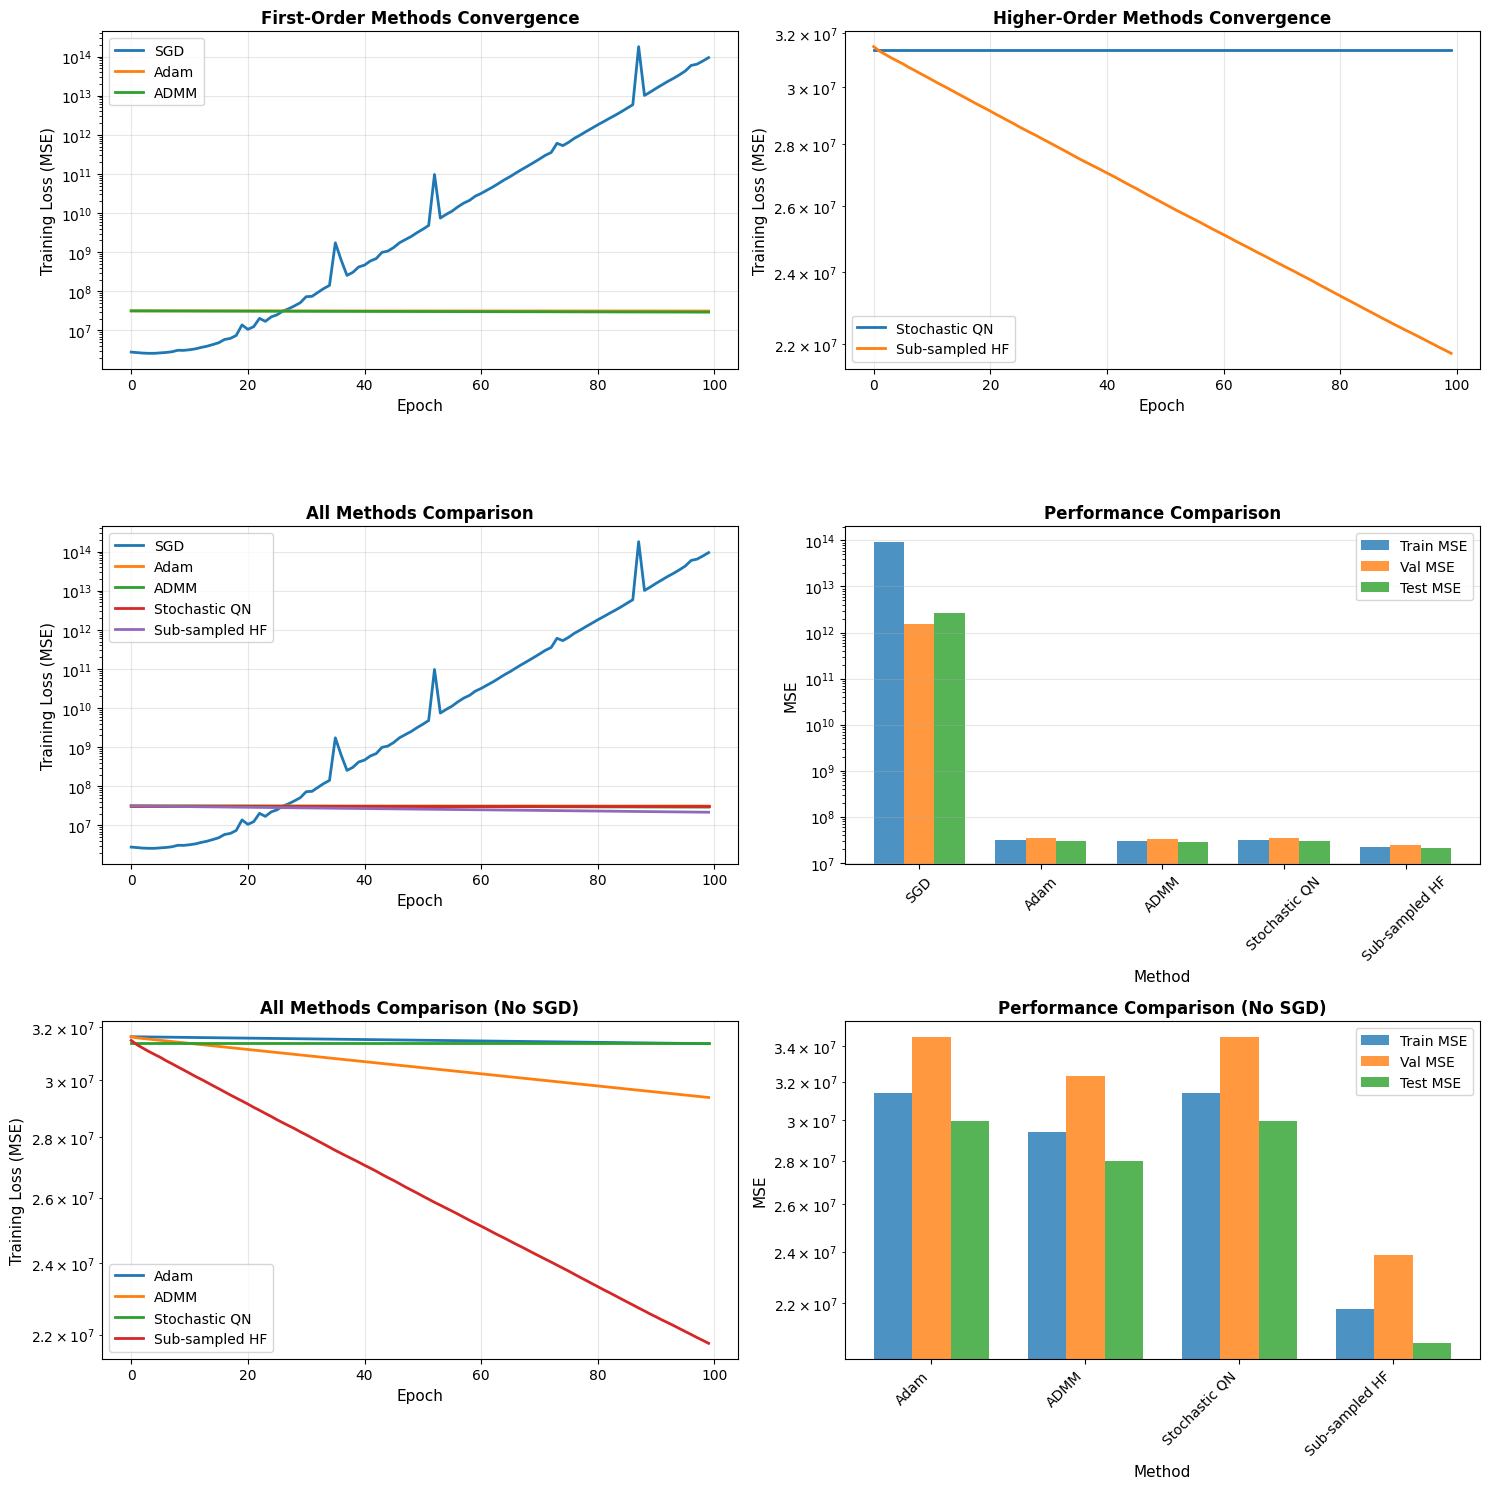

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, feature_names = load_data()

if X_train is not None:
    for model_name, (model_func, param_grid) in models_to_tune.items():
        best_hyperparams[model_name] = tune_hyperparameters(model_func, param_grid, X_train, y_train, X_val, y_val)
        print(f"Best hyperparames for {model_name} are {best_hyperparams[model_name]}\n")

results, coef_table, perf_table = evaluate_optimizers(X_train, y_train, X_val, y_val, X_test, y_test, feature_names, best_hyperparams)